
##Image Segmentation




In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 

In [ ]:
cwd = os.getcwd()

Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/Development_Dataset.zip

In [ ]:
!ls /content/Development_Dataset/

#DataSet

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_dir = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if input_dir:
  inp_img_data_gen = ImageDataGenerator(validation_split =0.2)
  inp_mask_data_gen = ImageDataGenerator(validation_split =0.2,)

In [ ]:
apply_data_augmentation = True
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
    
test_img_data_gen = ImageDataGenerator()

In [ ]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Development_Dataset')

# img

# Batch size
bs = 16

# img shape
img_h = 256
img_w = 256


# Training
img_training_dir = os.path.join(dataset_dir, 'Training/Bipbip/Haricot/')
train_img_gen = inp_img_data_gen.flow_from_directory(img_training_dir,
                                                       classes = ['Images'],
                                               target_size=(img_h, img_w),
                                                       batch_size=bs,
                                                       class_mode=None, 
                                                     interpolation='bilinear',
                                                       shuffle=True,
                                                       
                                                       seed=SEED,
                                                       subset='training')  # targets are directly converted into one-hot vectors
mask_training_dir = os.path.join(dataset_dir, 'Training/Bipbip/Haricot/')
train_mask_gen = inp_mask_data_gen.flow_from_directory(mask_training_dir,
                                               classes = ['Masks'],
                                               batch_size=bs, 
                                               class_mode=None,
                                               interpolation='bilinear',
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')  # targets are directly converted into one-hot vectors
train_gen = zip(train_img_gen, train_mask_gen)

valid_img_gen = inp_img_data_gen.flow_from_directory(img_training_dir,
                                                  classes = ['Images'],
                                                  target_size=(img_h, img_w),
                                                       batch_size=bs,
                                                       class_mode=None, 
                                                     interpolation='bilinear',
                                                       shuffle=False,
                                                       
                                                       seed=SEED,
                                                  subset='validation')
valid_mask_gen = inp_mask_data_gen.flow_from_directory(mask_training_dir,
                                                  classes = ['Masks'],
                                                  target_size=(img_h, img_w),
                                                  interpolation='bilinear',
                                                       batch_size=bs,
                                                       class_mode=None, 
                                                       shuffle=False,
                                                      
                                                       seed=SEED,
                                                  subset='validation')
valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 72 images belonging to 1 classes.
Found 72 images belonging to 1 classes.
Found 18 images belonging to 1 classes.
Found 18 images belonging to 1 classes.


In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, gen, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    
    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.gen = gen

  def __len__(self):
    return len(self.gen.filenames)

  def __getitem__(self, index):
    # Read Image
    c = self.gen.filenames[index]
    c1 = c.split('/')
    c2 = c1[1].split('.')
    curr_filename = c2[0]
    if self.which_subset == 'training':
      img = Image.open(os.path.join(self.dataset_dir, 'Training/Bipbip/Haricot/Images', curr_filename + '.jpg'))
      mask = Image.open(os.path.join(self.dataset_dir, 'Training/Bipbip/Haricot/Masks', curr_filename + '.png'))
    else:
      img = Image.open(os.path.join(self.dataset_dir, 'Training/Bipbip/Haricot/Images', curr_filename + '.jpg'))
      mask = Image.open(os.path.join(self.dataset_dir, 'Training/Bipbip/Haricot/Masks', curr_filename + '.png'))

   # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    new_mask_arr = np.expand_dims(new_mask_arr, -1)


    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(new_mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)

        out_mask = np.zeros_like(new_mask_arr)
        for c in np.unique(new_mask_arr):
          if c > 0:
            curr_class_arr = np.float32(new_mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = new_mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

dataset = CustomDataset('/content/Development_Dataset/', 'training', gen = train_img_gen,
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset('/content/Development_Dataset', 'validation', gen = valid_img_gen,
                              preprocessing_function=preprocess_input)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
# def prepare_target(x_, y_):
#     return x_, tf.cast(tf.reduce_any(y_ > 0, axis=-1, keepdims=True), tf.float32)

# train_dataset = train_dataset.map(prepare_target)




train_dataset = train_dataset.batch(32)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

valid_dataset = valid_dataset.batch(32)

valid_dataset = valid_dataset.repeat()

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


iterator = iter(train_dataset)

[0. 1. 2.]


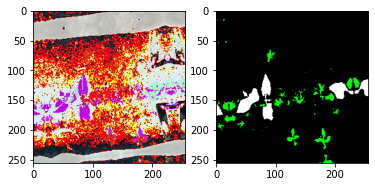

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = [255, 255, 255]
target_img[np.where(target == 2)] = [0, 255, 0]
# target_img[np.where(target == 3)] = [255, 0, 0]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

#Model

In [ ]:
# from tensorflow.keras.applications import ResNet50V2
# vgg = tf.keras.applications.ResNet50V2(weights='imagenet',include_top=False, input_shape=(img_h, img_w, 3))

# from tensorflow.keras.applications import DenseNet201
# vgg = tf.keras.applications.DenseNet201(weights='imagenet',include_top=False, input_shape=(img_h, img_w, 3))

from tensorflow.keras.applications import VGG16
vgg = tf.keras.applications.VGG16(weights='imagenet',include_top=False, input_shape=(img_h, img_w, 3))
finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=3)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 1920)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       4423936   
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 128)       0

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,2): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), monitor='val_meanIoU',
                                                   verbose=1, save_best_only=True, mode='max',
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=5, mode='max')
    callbacks.append(es_callback)



# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [ ]:
model.fit(x=train_dataset,
          epochs=3,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/3
72/72 [==============================] - 3356s 46s/step - loss: 0.5737 - accuracy: 0.8187 - meanIoU: 0.0033 - val_loss: 11.4271 - val_accuracy: 0.9201 - val_meanIoU: 1.2340e-12

Epoch 00001: val_meanIoU improved from -inf to 0.00000, saving model to /content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec28_13-13-42/ckpts/cp_01.ckpt
Epoch 2/3
72/72 [==============================] - 3330s 46s/step - loss: 0.2140 - accuracy: 0.9018 - meanIoU: 1.6832e-05 - val_loss: 0.3003 - val_accuracy: 0.9201 - val_meanIoU: 1.2340e-12

Epoch 00002: val_meanIoU did not improve from 0.00000
Epoch 3/3
72/72 [==============================] - 3336s 46s/step - loss: 0.1828 - accuracy: 0.9166 - meanIoU: 0.1405 - val_loss: 0.1825 - val_accuracy: 0.9301 - val_meanIoU: 0.2829

Epoch 00003: val_meanIoU improved from 0.00000 to 0.28293, saving model to /content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec28_13-13-42/ckpts/cp_03.ckpt


In [ ]:
model.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec28_13-13-42/ckpts/cp_03.ckpt')

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

#View the Result

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = [255, 255, 255]
target_img[np.where(target == 2)] = [0, 255, 0]
target_img[np.where(target == 3)] = [255, 0, 0]

# prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
prediction_img[np.where(predicted_class == 1)] = [255, 255, 255]
prediction_img[np.where(predicted_class == 2)] = [0, 255, 0]
prediction_img[np.where(predicted_class == 3)] = [255, 0, 0]

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

#Preparing the Submission

In [ ]:
#getting test images
from keras.preprocessing.image import save_img
def submit(submission_dict,team,crop):
    path_mask='Development_Dataset/Test_Dev/Bipbip/Haricot/Masks'
    if not os.path.exists(path_mask):
      os.mkdir(path_mask)
    path ="Development_Dataset/Test_Dev/"
    dir= os.path.join(path,team,crop,'Images')
    predicted_images =next(os.walk(dir))[2]
    print (type(predicted_images))
    for img in predicted_images:
      mask_img = img.split(".")
      mask_img=mask_img[0]
      test_image = Image.open(os.path.join(dir,img))
      #print (test_image)
      size=(256,256)
      test_image = test_image.resize(size)
      tf_test_image = tf.convert_to_tensor(
      np.array(test_image), dtype='float32'
      )
      out_sigmoid = model.predict(x=tf.expand_dims(tf_test_image, 0))
      predicted_class = tf.argmax(out_sigmoid, -1)
      predicted_class = predicted_class[0, ...]

      prediction_img = np.zeros([tf_test_image.shape[0], tf_test_image.shape[1], 3])
      prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
      prediction_img[np.where(predicted_class == 1)] = [255, 255, 255]
      prediction_img[np.where(predicted_class == 2)] = [216, 67, 82]
      #print(predicted_class)
      #path_mask=/content/Bipbip_haricot_im_00211.png
      save_img('Development_Dataset/Test_Dev/Bipbip/Haricot/Masks/' + mask_img + '.png',prediction_img)

      mask_arr=read_rgb_mask("Development_Dataset/Test_Dev/Bipbip/Haricot/Masks/" + mask_img + '.png')
      #print(mask_arr)
      submission_dict[mask_img] = {}
      submission_dict[mask_img]['shape'] = mask_arr.shape
      submission_dict[mask_img]['team'] = team
      submission_dict[mask_img]['crop'] = crop
      submission_dict[mask_img]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[mask_img]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[mask_img]['segmentation']['weed'] = rle_encoded_weed
      print(submission_dict)
    return submission_dict
# path ="Development_Dataset/Test_Dev/"
# dir= os.path.join(path,'Bibip/','Haricot/','Images')
# predicted_images =next(os.walk(dir))[2]
# for img in predicted_images:
#   test_image = Image.open(os.path.join(dir,img))
#   print(test_image)

In [ ]:
#reading rgb masks

import os
import numpy as np
from PIL import Image


def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr


# if __name__ == "__main__":

#     # Read the example RGB mask and transform it into integer labels.

#     mask = read_rgb_mask("./predictions/rgb_mask_example.png")

#     np.save("./predictions/arr_mask_example.npy", mask)

In [ ]:
import os
import json
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
#def submission():
submission_dict = {}

submission_dict = submit(submission_dict,'Bipbip','Haricot')

<class 'list'>
{'Bipbip_haricot_im_02901': {'shape': (256, 256), 'team': 'Bipbip', 'crop': 'Haricot', 'segmentation': {'crop': '30102 4 30211 1 30357 6 30467 2 30524 5 30612 8 30723 2 30778 9 30867 10 30979 4 31033 11 31122 11 31235 8 31288 14 31377 12 31491 9 31543 16 31633 12 31746 11 31798 18 31888 13 32002 12 32054 19 32144 13 32258 12 32310 20 32399 14 32514 13 32565 21 32655 14 32770 13 32821 22 32911 14 33026 13 33077 23 33166 15 33282 13 33333 24 33422 15 33538 14 33589 25 33678 15 33794 14 33845 25 33934 15 34050 14 34101 26 34189 15 34306 13 34357 26 34445 15 34562 13 34613 27 34701 15 34818 12 34869 27 34957 15 35074 12 35126 27 35213 15 35330 10 35382 27 35468 16 35587 8 35638 28 35724 16 35843 7 35895 27 35980 16 36099 3 36151 27 36236 15 36355 2 36408 27 36492 15 36611 2 36664 27 36747 16 36867 1 36921 26 37003 16 37177 26 37259 16 37434 25 37515 16 37690 25 37771 16 37947 24 38027 16 38204 22 38283 16 38460 22 38538 17 38717 21 38794 17 38974 19 39050 17 39231 18 39306 1

In [ ]:
with open('submission.json', 'w') as f:
  json.dump(submission_dict, f)